In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/getdatachimp/demo/main/prep/borked_iris.csv')
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y = df['variety'].map({'Setosa': 0, 'Versicolor': 1, 'Virginica': 2})
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [3]:
pipeline = make_pipeline(
  StandardScaler(),
  LogisticRegression()
)

model = pipeline.fit(X_train, y_train)

In [4]:
model.score(X_test, y_test)

0.7368421052631579

In [5]:
from doubtlab.ensemble import DoubtEnsemble
from doubtlab.reason import ProbaReason, WrongPredictionReason
reasons = {
    'proba': ProbaReason(model=model),
    'wrong_pred': WrongPredictionReason(model=model)
}

# Pass these reasons to a doubtlab instance.
doubt = DoubtEnsemble(**reasons)

# Get the ordered indices of examples worth checking again
indices = doubt.get_indices(X_train, y_train)
# Get dataframe with "reason"-ing behind the sorting
predicates = doubt.get_predicates(X_train, y_train)

In [6]:
df = df.join(predicates).drop(['Unnamed: 0'], axis=1)
df.iloc[predicates.index].head(len(indices))

,sepal_length,sepal_width,petal_length,petal_width,variety,collector,predicate_proba,predicate_wrong_pred
99,5.7,2.8,4.1,1.3,Versicolor,Eric,1.0,1.0
55,5.7,2.8,4.5,1.3,Versicolor,Eric,1.0,1.0
92,5.8,2.6,4.0,1.2,Versicolor,Eric,1.0,1.0
41,4.5,2.3,1.3,0.3,Setosa,Sam,1.0,1.0
96,5.7,2.9,4.2,1.3,Versicolor,Eric,1.0,1.0
68,6.2,2.2,4.5,1.5,Versicolor,Eric,1.0,1.0
64,5.6,2.9,3.6,1.3,Versicolor,Eric,1.0,1.0
61,5.9,3.0,4.2,1.5,Versicolor,Eric,0.0,1.0
106,4.9,2.5,4.5,1.7,Virginica,Sam,0.0,1.0
87,6.3,2.3,4.4,1.3,Versicolor,Eric,0.0,1.0


Eric is always associated with doubtly doubtful predictions. What's up with that? Pairplot colored by collector could be helpful here.

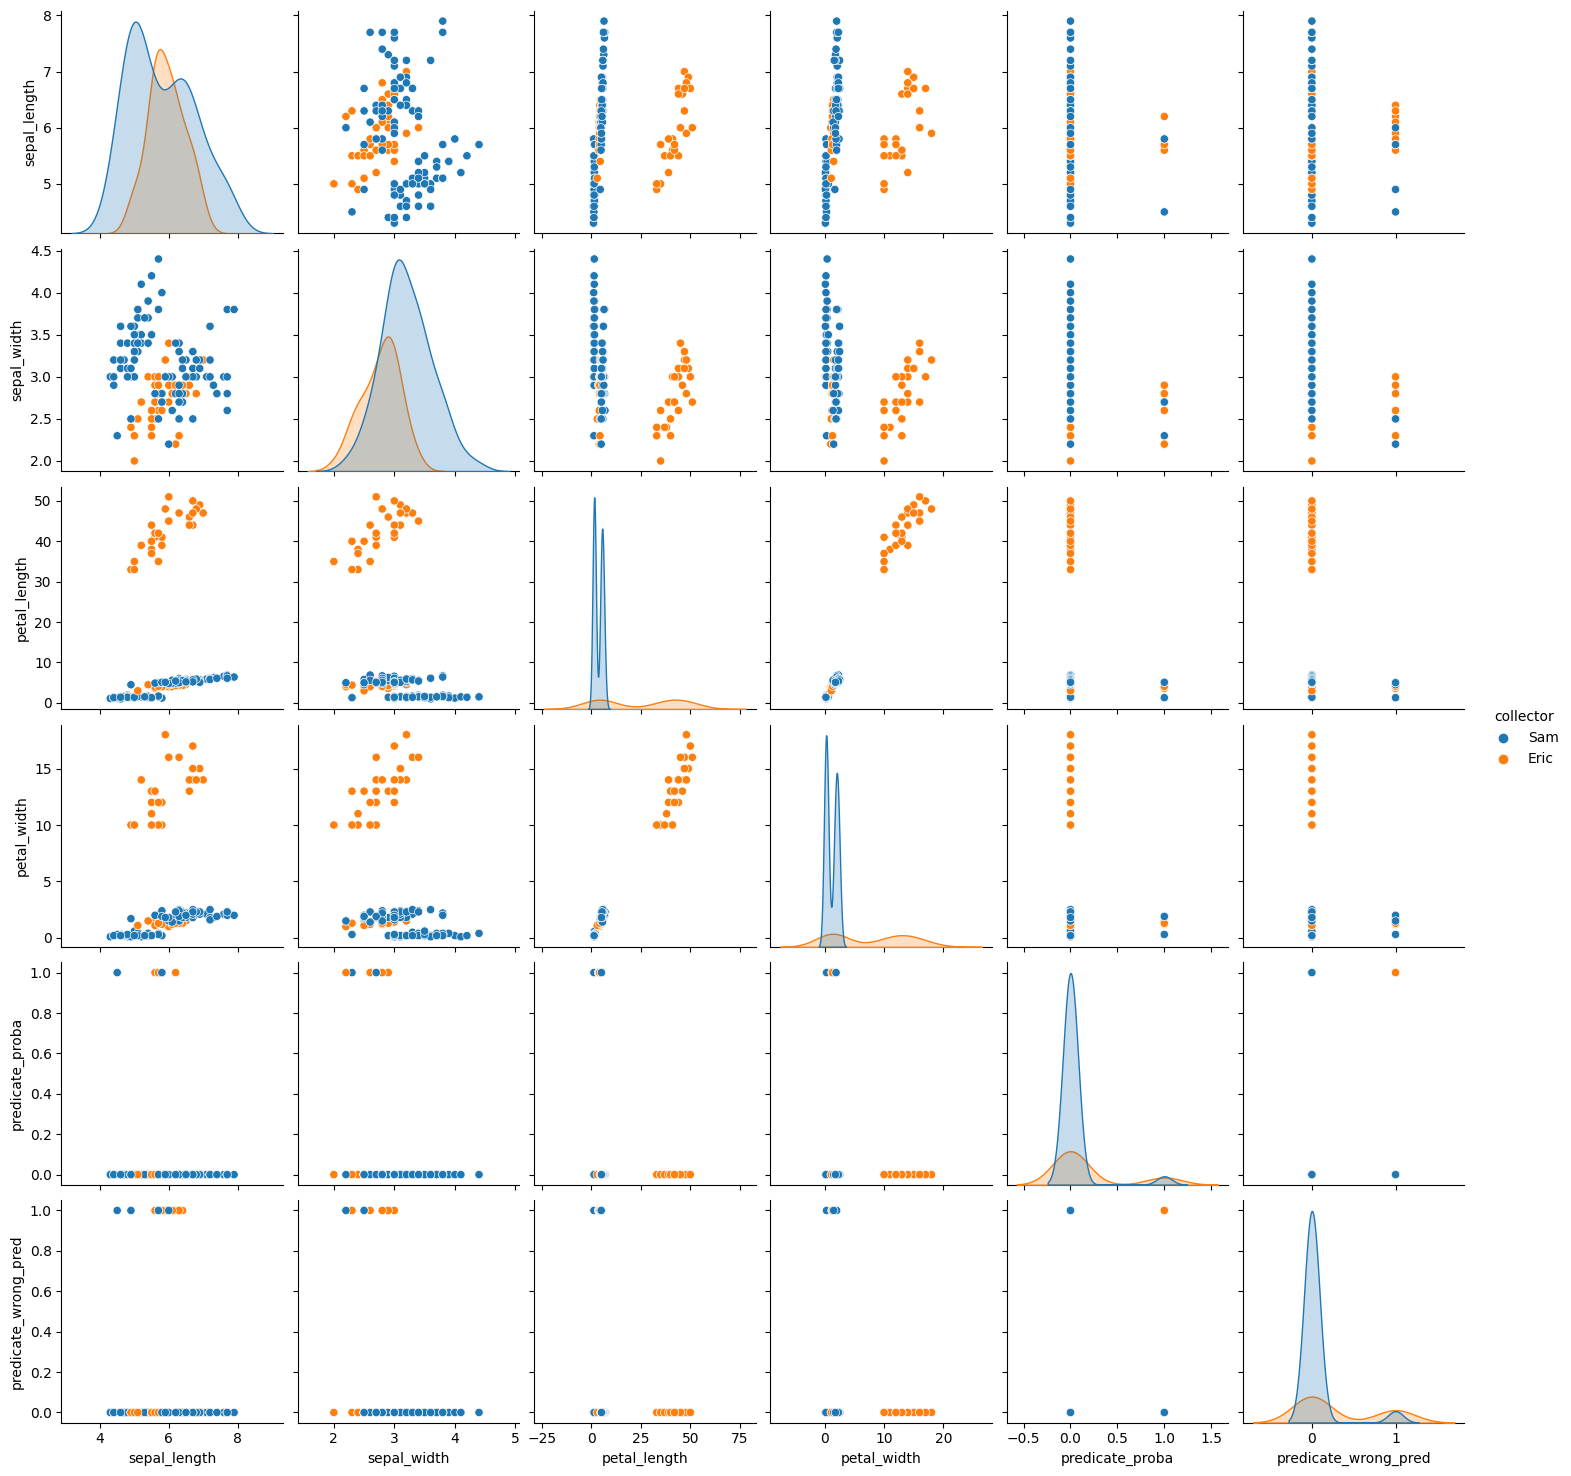

In [7]:
import seaborn as sns
sns.pairplot(data=df, hue='collector')

Notice how different the distributions are different by collector for petal_length and petal_width

In [8]:
# Use pandera to create simple check that features >= some values
import pandera as pa

schema = pa.DataFrameSchema({
  'variety': pa.Column(str),
  'petal_length': pa.Column(float, [
    pa.Check(lambda g: g['Versicolor'].max() <= 30, groupby='variety'), 
    pa.Check(lambda g: g['Setosa'] <= 10, groupby='variety'),
    pa.Check(lambda g: g['Virginica'] <= 40, groupby='variety')
    ])
})

schema.validate(df)

SchemaError: <Schema Column(name=petal_length, type=DataType(float64))> failed series or dataframe validator 0:
<Check <lambda>>

In [9]:
df.loc[df['collector'] == 'Eric', 'petal_length'] /= 100
df.loc[df['collector'] == 'Eric', 'petal_width'] /= 100

In [20]:
schema.validate(df)

,sepal_length,sepal_width,petal_length,petal_width,variety,collector,predicate_proba,predicate_wrong_pred
0,5.1,3.5,1.4,0.2,Setosa,Sam,0.0,0.0
1,4.9,3.0,1.4,0.2,Setosa,Sam,0.0,0.0
2,4.7,3.2,1.3,0.2,Setosa,Sam,0.0,0.0
3,4.6,3.1,1.5,0.2,Setosa,Sam,0.0,0.0
4,5.0,3.6,1.4,0.2,Setosa,Sam,0.0,0.0
...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica,Sam,0.0,0.0
146,6.3,2.5,5.0,1.9,Virginica,Sam,0.0,0.0
147,6.5,3.0,5.2,2.0,Virginica,Sam,0.0,0.0
148,6.2,3.4,5.4,2.3,Virginica,Sam,0.0,0.0


In [ ]:
# If there's time, use pandera for hypothesis testing check for something more robust

,sepal_length,sepal_width,petal_length,petal_width,variety,collector,predicate_proba,predicate_wrong_pred
0,5.1,3.5,1.4,0.2,Setosa,Sam,0.0,0.0
2,4.7,3.2,1.3,0.2,Setosa,Sam,0.0,0.0
6,4.6,3.4,1.4,0.3,Setosa,Sam,0.0,0.0
7,5.0,3.4,1.5,0.2,Setosa,Sam,NaN,NaN
8,4.4,2.9,1.4,0.2,Setosa,Sam,NaN,NaN
10,5.4,3.7,1.5,0.2,Setosa,Sam,0.0,0.0
12,4.8,3.0,1.4,0.1,Setosa,Sam,0.0,0.0
14,5.8,4.0,1.2,0.2,Setosa,Sam,0.0,0.0
15,5.7,4.4,1.5,0.4,Setosa,Sam,0.0,0.0
18,5.7,3.8,1.7,0.3,Setosa,Sam,NaN,NaN


In [1]:
# Setup data chimp checks


{
  "shell_port": 9002,
  "iopub_port": 9004,
  "stdin_port": 9003,
  "control_port": 9001,
  "hb_port": 9000,
  "ip": "127.0.0.1",
  "key": "d58c693d-5a16-485a-956e-3a918d219c7a",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-v2-69066ELG84BcAjFrd.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [1]:
%connect_info

{
  "shell_port": 9002,
  "iopub_port": 9004,
  "stdin_port": 9003,
  "control_port": 9001,
  "hb_port": 9000,
  "ip": "127.0.0.1",
  "key": "4529bb63-ff5b-4601-b62b-ede2d55188ca",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-v2-55034BNxRIhvdaYL0.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [ ]:
#Here's what you can type into default.ipynb
import pandera as pa
from pandera.errors import SchemaError

schema = pa.DataFrameSchema({
  'variety': pa.Column(str),
  'petal_length': pa.Column(float, [
    pa.Check(lambda g: g['Versicolor'].min() <= 30, groupby='variety'), 
    pa.Check(lambda g: g['Setosa'] <= 10, groupby='variety'),
    pa.Check(lambda g: g['Virginica'] <= 40, groupby='variety')
    ])
})

def validate():
  try:
    schema.validate(df)
    return None
  except SchemaError as ex:
    return ex.failure_cases
validate()

In [244]:
df.loc[df['collector'] == 'Eric', 'petal_length'] *= 100
df.loc[df['collector'] == 'Eric', 'petal_width'] *= 100

,sepal_length,sepal_width,petal_length,petal_width,variety,collector,predicate_proba,predicate_wrong_pred
0,5.1,3.5,1.400000,0.200000,Setosa,Sam,0.0,0.0
1,4.9,3.0,0.033635,0.004805,Setosa,Eric,0.0,0.0
2,4.7,3.2,1.300000,0.200000,Setosa,Sam,0.0,0.0
3,4.6,3.1,0.036038,0.004805,Setosa,Eric,0.0,0.0
4,5.0,3.6,0.033635,0.004805,Setosa,Eric,0.0,0.0
...,...,...,...,...,...,...,...,...
145,6.7,3.0,0.124931,0.055258,Virginica,Eric,0.0,0.0
146,6.3,2.5,5.000000,1.900000,Virginica,Sam,0.0,0.0
147,6.5,3.0,5.200000,2.000000,Virginica,Sam,0.0,0.0
148,6.2,3.4,0.129736,0.055258,Virginica,Eric,1.0,0.0


In [21]:
df

,sepal_length,sepal_width,petal_length,petal_width,variety,collector,predicate_proba,predicate_wrong_pred
0,5.1,3.5,1.4,0.2,Setosa,Sam,0.0,0.0
1,4.9,3.0,1.4,0.2,Setosa,Sam,0.0,0.0
2,4.7,3.2,1.3,0.2,Setosa,Sam,0.0,0.0
3,4.6,3.1,1.5,0.2,Setosa,Sam,0.0,0.0
4,5.0,3.6,1.4,0.2,Setosa,Sam,0.0,0.0
...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica,Sam,0.0,0.0
146,6.3,2.5,5.0,1.9,Virginica,Sam,0.0,0.0
147,6.5,3.0,5.2,2.0,Virginica,Sam,0.0,0.0
148,6.2,3.4,5.4,2.3,Virginica,Sam,0.0,0.0


In [ ]:
# Deploy pipeline to civo

In [ ]:
# If there's time, show cleanlab demo